Stephanie Chiang
DATA 620 Summer 2025
Final Project
# Final Words
### An Analysis of the Last Statements of Death Row Inmates Using Natural Language Processing and Network Analysis

### Introduction

This project aims to examine the “last words” of death row inmates by using their official final statements, as published on the [Texas Department of Criminal Justice website](https://www.tdcj.texas.gov/death_row/dr_executed_offenders.html).

My focus here is in trying to understand what people facing the end of their lives think and feel. This type of data is almost impossible (and perhaps ethically dubious) to collect systematically from the general population. However, inmates in Texas facing execution are given the chance to make final statements, which have been collected since at least 1982. I plan to use this publicly available data to explore the language of last statements for any patterns which may reveal insights into emotional states and common themes. I hope to do this with sensitivity and respect for the individuals involved.

By using NLP, my goal is to be able to illuminate what people feel, think and value when death is imminent. Then, by forming networks between word usage and inmate demographic data, I want to examine how different groups of people might express their final words differently. This is a universal human experience and my hope that this information would be helpful to any others facing the same. In effect, this is all of us, just on different time scales.

### Data Collection

The data is collected from the Texas Department of Criminal Justice website, which provides a list of executed inmates and their last statements. The scraping process involves:
1. Fetching the main page containing individual inmate data and links to last statement pages.
2. Extracting the URL of each inmate's page.
3. Visiting each link to scrape the inmate's last statement.
4. Storing the data in a structured format for analysis.

I will use the Beautiful Soup library to parse the HTML and extract the relevant information. The final dataset will include the inmate's name, last statement, and some demographic details.

In [ ]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

# Get the main page table and parse
base_url = "https://www.tdcj.texas.gov"
table_url = urljoin(base_url, "/death_row/dr_executed_offenders.html")

response = requests.get(table_url, verify=False)
response.raise_for_status()

soup = BeautifulSoup(response.text, "html.parser")

# Extract the links from the 3rd column and other relevant data
links = []

for row in soup.find_all("tr"):
    cells = row.find_all("td")
    if cells:
        id = cells[0].get_text(strip=True)
        last_name = cells[3].get_text(strip=True)
        first_name = cells[4].get_text(strip=True)
        age = cells[6].get_text(strip=True)
        date = cells[7].get_text(strip=True)
        race = cells[8].get_text(strip=True)

        link_tag = cells[2].find("a")
        slug = link_tag.get("href")

        # Skip rows with no last statement
        if "no_last_statement" in slug:
            continue
        # Ensure slugs are correctly formatted
        if slug and not slug.startswith("/death_row/"):
            slug = "/death_row/" + slug
        # Construct a row in the draft data
        if link_tag and slug:
            href = urljoin(base_url, slug)
            links.append([id, last_name, first_name, age, date, race, href])

print(f"Found {len(links)} links.")

Found 493 links.


In [ ]:
# Visit each link, parse and scrape data
scraped_data = []

for row in links:
    url = row[-1]
    try:
        page_response = requests.get(url, verify=False)
        page_response.raise_for_status()
        page_soup = BeautifulSoup(page_response.text, "html.parser")

        statement = page_soup.find_all("p")[5].get_text(strip=True) if page_soup.find("p") else "NA"
        scraped_data.append(row + [statement])
    except Exception as e:
        print(f"Failed to scrape {url}: {e}")

print(f"Scraped {len(scraped_data)} rows.")

Failed to scrape https://www.tdcj.texas.gov/death_row/dr_info/bibledannylast.html: list index out of range
Scraped 492 rows.


The above scraping took about 2 minutes and resulted in 1 error, due to a page layout issue. A quick check confirms there is no recorded statement for this person.

Below, the data can be saved as a CSV before proceeding to analysis.

In [80]:
import csv

csv_filename = "dr_scraped.csv"

with open(csv_filename, "w", newline="", encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["id", "last_name", "first_name", "age", "date", "race", "url", "statement"])
    writer.writerows(scraped_data)

print(f"Saved to '{csv_filename}'")

Saved to 'dr_scraped.csv'


### Exploratory Data Analysis & Visualization

First, we will prepare the data so that some of the demographic details can be visualized. I want to paint the fullest possible picture of the people whose statements are being examined.

Using the pandas library, the dataframe is tidied and formatted, and missing values excluded. 

In [416]:
import pandas as pd

# Convert to pandas dataframe
dr_df = pd.DataFrame(scraped_data, columns=["id", "last_name", "first_name", "age", "date", "race", "url", "statement"])

# Convert 'id' and 'age' to integer
dr_df['id'] = pd.to_numeric(dr_df['id'], errors='coerce')
dr_df['age'] = pd.to_numeric(dr_df['age'], errors='coerce')

# Convert 'race' to categorical and check levels
dr_df['race'] = dr_df['race'].astype('category')

# Convert 'date' to datetime
dr_df['date'] = pd.to_datetime(dr_df['date'], errors='coerce')

# Drop rows with missing statements
missing1 = dr_df[dr_df['statement'].str.contains("no last statement|no statement", case=False, na=False)].index
dr_df = dr_df.drop(missing1)
missing2 = dr_df[dr_df['statement'] == "None"].index
dr_df = dr_df.drop(missing2)
missing3 = dr_df[dr_df['statement'] == "None."].index
dr_df = dr_df.drop(missing3)

print(dr_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 484 entries, 0 to 491
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          484 non-null    int64         
 1   last_name   484 non-null    object        
 2   first_name  484 non-null    object        
 3   age         484 non-null    int64         
 4   date        484 non-null    datetime64[ns]
 5   race        484 non-null    category      
 6   url         484 non-null    object        
 7   statement   484 non-null    object        
dtypes: category(1), datetime64[ns](1), int64(2), object(4)
memory usage: 30.9+ KB
None


In [417]:
print(dr_df.head(5))

    id last_name first_name  age       date      race  \
0  595   Johnson    Matthew   50 2025-05-20     Black   
1  594   Mendoza     Moises   41 2025-04-23  Hispanic   
2  593    Tabler    Richard   46 2025-02-13     White   
3  592    Nelson     Steven   37 2025-02-05     Black   
4  591     White     Garcia   61 2024-10-01     Black   

                                                 url  \
0  https://www.tdcj.texas.gov/death_row/dr_info/j...   
1  https://www.tdcj.texas.gov/death_row/dr_info/m...   
2  https://www.tdcj.texas.gov/death_row/dr_info/t...   
3  https://www.tdcj.texas.gov/death_row/dr_info/n...   
4  https://www.tdcj.texas.gov/death_row/dr_info/w...   

                                           statement  
0  First and foremost, I would like to give all p...  
1  To Mark, Pam, Austin, Uncle Troy, and Jose, I ...  
2  There is not a day that goes by that I don't r...  
3  I will always love you no matter, that our lov...  
4  Yes ma'am, first I would like to apologize

A histogram can visualize the distribution of inmates' ages. Below we can see that most of the executed inmates were around 30 to the mid-40s, with a large spike at just under the age of 40. This dispiriting statistic skews younger than I had expected. In regards to our analysis, this indicates that the statements have mostly come from people who were not otherwise expecting to be close the end of their lives. It's possible they would not have yet confronted the concept of death if not for their incarceration.

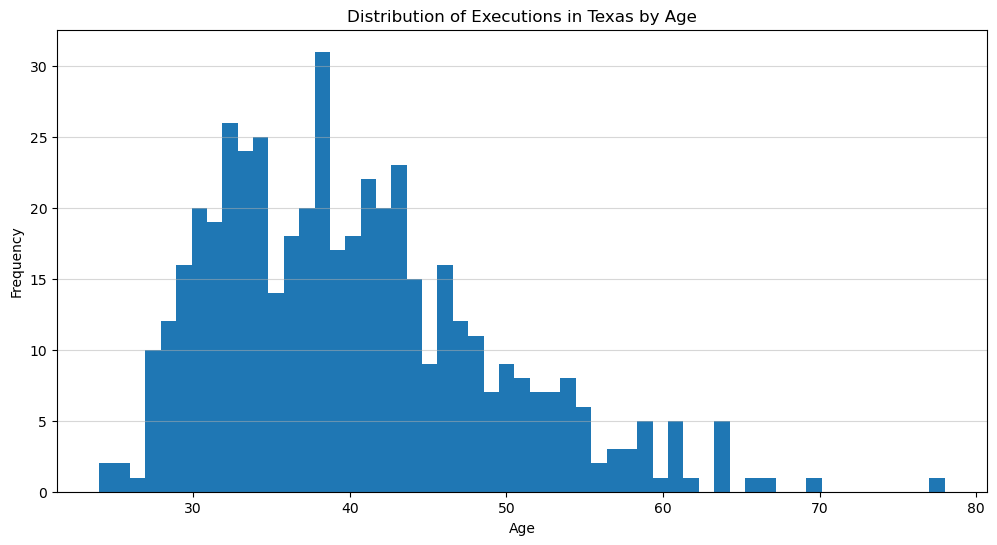

In [418]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.hist(dr_df['age'], bins=55)
plt.title('Distribution of Executions in Texas by Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)
plt.show()

We can also see that a large majority of collected statements were on the shorter side, with only a few outliers over 400 words. Though this does not yet give full insight into the content of those statements, this could point to a more limited variety of chosen words.

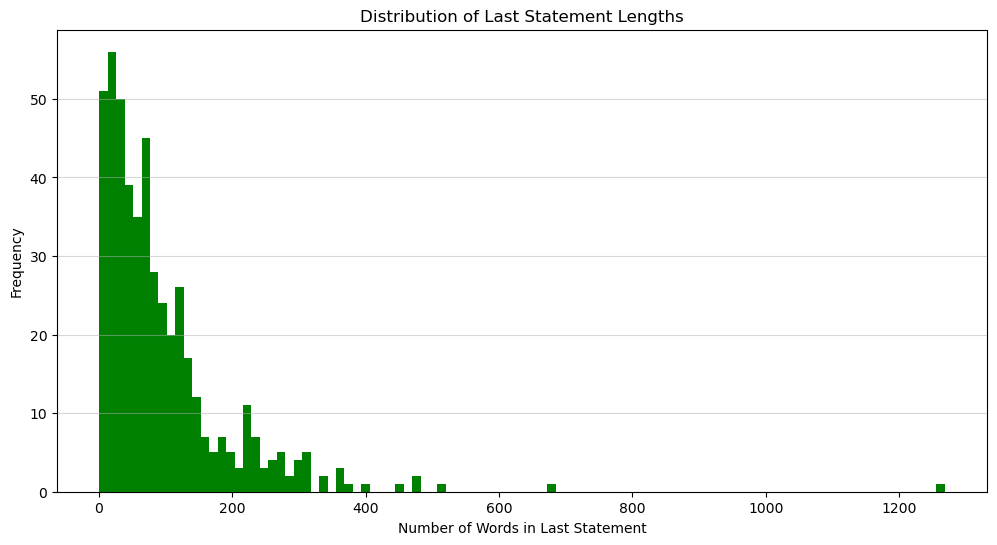

In [419]:
dr_df['statement_length'] = dr_df['statement'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12, 6))
plt.hist(dr_df['statement_length'], bins=100, color='green')
plt.title('Distribution of Last Statement Lengths')
plt.xlabel('Number of Words in Last Statement')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)
plt.show()

### Natural Language Processing

Using the NLTK library, we can now perform language processing and sentiment analysis, beginning with determining the most frequently used words when all the statements are combined into a singe corpus.

In [420]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

# Combine all statements into one large string and tokenize
all_text = " ".join(dr_df["statement"].tolist())
tokens = word_tokenize(all_text)

# Convert to lowercase, remove non-alphabetic words and stop words (e.g., 'the', 'is', 'and', etc.)
words = [word.lower() for word in tokens if word.isalpha()]
stop_words = set(stopwords.words("english"))
filtered_words = [word for word in words if word not in stop_words]

# Unique words
unique_words = set(filtered_words)
print(f"Number of unique words: {len(unique_words)}")

# Word frequencies
word_freq = Counter(filtered_words)

# Most common words
top_words = word_freq.most_common(10)
print("Top 10 words:")
for word, freq in top_words:
    print(f"{word}: {freq}")

Number of unique words: 3053
Top 10 words:
love: 752
family: 359
know: 343
thank: 327
sorry: 281
want: 260
would: 255
like: 239
god: 237
say: 182


Of the 3053 unique words, I found that the top 10 most frequent illustrated the humanity of those facing their end. 

The single most commonly used word was 'love' by far, joined by other expressions of emotional and spiritual connection, like 'god' and 'family'. Other words were manifestions of their desire to communicate final thoughts and feelings, including 'sorry', 'thank you' and other tokens likely used in combination: 'would', 'like', 'say', 'want' and 'know'.

Below, the curve representing word frequencies generally followed the phenomenon of Zips's Law.

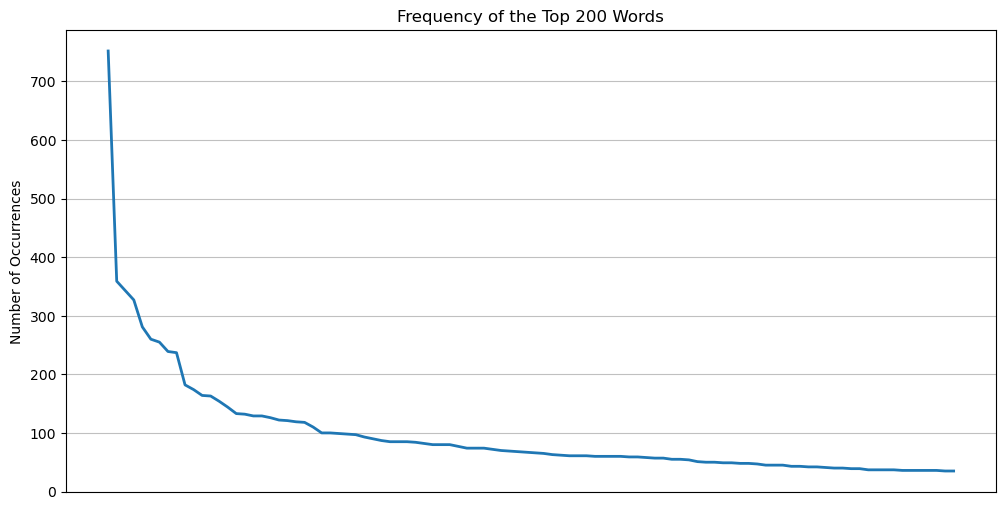

In [421]:
from nltk.probability import FreqDist

fdist = FreqDist(filtered_words)

plt.figure(figsize=(12, 6))
fdist.plot(100, cumulative=False)
plt.title('Frequency of the Top 200 Words')
plt.xticks([])
plt.xlabel('')
plt.ylabel('Number of Occurrences')
plt.show()

### Bimodal Network Analysis

I would now like to examine how top words were used in connection with each other, and if there are any noticeable patterns in how each inmate expressed themselves based their race, age or year of death.

For this, the statements will need to be tokenized per row so that we can form a graph using Networkx. Nodes will represent either a person or a frequently used token/word. Edges will represent the appearance of that word in the person's final statement.

In [422]:
import networkx as nx

# Bin ages and years and add as new columns
bins = [0, 30, 40, 50, 60, 70, 100]
dr_df['age_range'] = pd.cut(dr_df['age'], bins=bins, labels=['<30', '31-40', '41-50', '51-60', '61-70', '71+'])
dr_df['decade'] = (dr_df['date'].dt.year // 10) * 10

# Tokenize rows with helper function and add new column
def row_tokenize(text):
    tokens = word_tokenize(text.lower())
    return [word for word in tokens if word.isalpha() and word not in stop_words]

dr_df["tokens"] = dr_df["statement"].apply(row_tokenize)

# Bipartite graph
B = nx.Graph()

# Add person nodes with metadata
for _, row in dr_df.iterrows():
    B.add_node(
        row["id"], 
        bipartite=0,
        label=row["id"],
        race=row["race"],
        age_range=row["age_range"],
        decade=row["decade"],
        node_type="person"
    )

top_str = [word for word, _ in top_words]

# Add word nodes
for word in top_str:
    B.add_node(
        word, 
        bipartite=1,
        label=word,
        node_type="word"
    )

# Add edges
for _, row in dr_df.iterrows():
    for word in row["tokens"]:
        if word in top_str:
            B.add_edge(row["id"], word)

print(B)

Graph with 494 nodes and 1729 edges


So with this graph of 484 nodes representing people and their attribute data, 10 nodes representing the top 10 words and the edges of word use between them, we can create a one-mode projection of the bipartite graph onto the word nodes.

In [423]:
from networkx.algorithms import bipartite

word_nodes = [n for n, d in B.nodes(data=True) if d["bipartite"] == 1]

word_graph = bipartite.projected_graph(B, word_nodes)
word_degrees = dict(word_graph.degree())
print(word_degrees)

word_graph_weighted = bipartite.weighted_projected_graph(B, word_nodes)
word_strength = dict(word_graph_weighted.degree(weight="weight"))
print(word_strength)

{'love': 9, 'family': 9, 'know': 9, 'thank': 9, 'sorry': 9, 'want': 9, 'would': 9, 'like': 9, 'god': 9, 'say': 9}
{'love': 1015, 'family': 898, 'know': 711, 'thank': 688, 'sorry': 594, 'want': 638, 'would': 661, 'like': 652, 'god': 530, 'say': 515}


When the bipartite graph is projected onto the word nodes, we can see above that, at first, all the nodes appear equally connected. But when we apply `weighted_projected_graph` to include weights representing the shared neighbors, we can see that there are differences in how strong each connection is.

In [424]:
wgw_edges = word_graph_weighted.edges(data=True)
sorted_edges = sorted(wgw_edges, key = lambda x: x[2]['weight'], reverse = True)

for u, v, data in sorted_edges[:25]:
    print(f"{u} - {v}: {data['weight']} statement co-occurences")

love - family: 167 statement co-occurences
love - know: 130 statement co-occurences
love - thank: 128 statement co-occurences
would - like: 117 statement co-occurences
love - want: 115 statement co-occurences
family - thank: 108 statement co-occurences
love - sorry: 101 statement co-occurences
love - would: 99 statement co-occurences
love - like: 99 statement co-occurences
family - would: 99 statement co-occurences
family - like: 99 statement co-occurences
family - sorry: 98 statement co-occurences
family - know: 97 statement co-occurences
love - god: 94 statement co-occurences
know - want: 94 statement co-occurences
family - want: 90 statement co-occurences
love - say: 82 statement co-occurences
thank - want: 79 statement co-occurences
thank - like: 74 statement co-occurences
family - god: 72 statement co-occurences
know - sorry: 72 statement co-occurences
know - thank: 72 statement co-occurences
thank - would: 70 statement co-occurences
family - say: 68 statement co-occurences
know -

The above truncated output shows that the words "love" and "family" occurred together the most, 167 times in our dataset. This is equal to, for example, the combined co-appearances of either "love" or "family" with "god".

The below co-occurrence web is completely connected; most of the words occurred together, perhaps demonstrating the universality of these concepts in final statements. The word nodes are, however, differently sized and colored by their weights. 

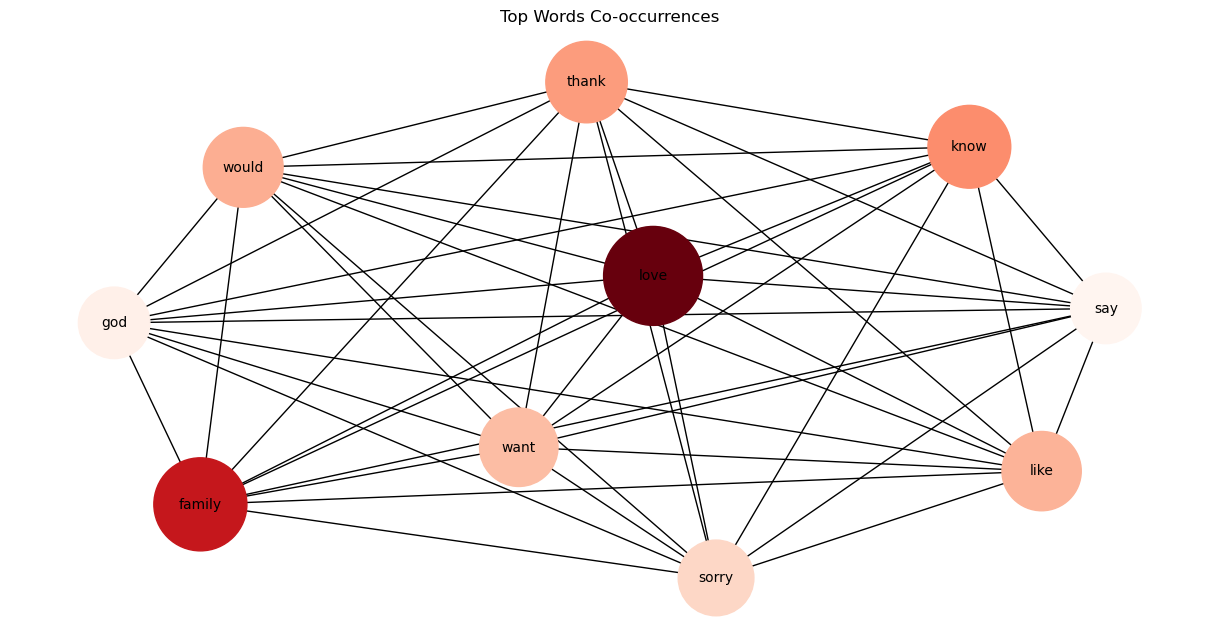

In [425]:
from itertools import combinations

G = nx.Graph()

for word in top_str:
    G.add_node(word, label=word)

# For each statement, find co-occurring pairs of top words and add edges
for tokens in dr_df["tokens"]:
    tw = [word for word in tokens if word in top_str]
    for word1, word2 in combinations(set(tw), 2):
        if not G.has_edge(word1, word2):
            G.add_edge(word1, word2)

node_sizes = [word_strength[n] * 5 for n in word_graph_weighted.nodes]
node_colors = [word_strength[n] for n in word_graph_weighted.nodes]

plt.figure(figsize=(12, 6))
pos = nx.spring_layout(G, seed=101)
nx.draw(G, pos, 
        with_labels=True, 
        node_color=node_colors,
        cmap=plt.cm.Reds,
        node_size=node_sizes, 
        font_size=10)

plt.title("Top Words Co-occurrences")
plt.show()

We can also form and visualize bipartite graphs based on the attributes of the people whose statements included the top words.

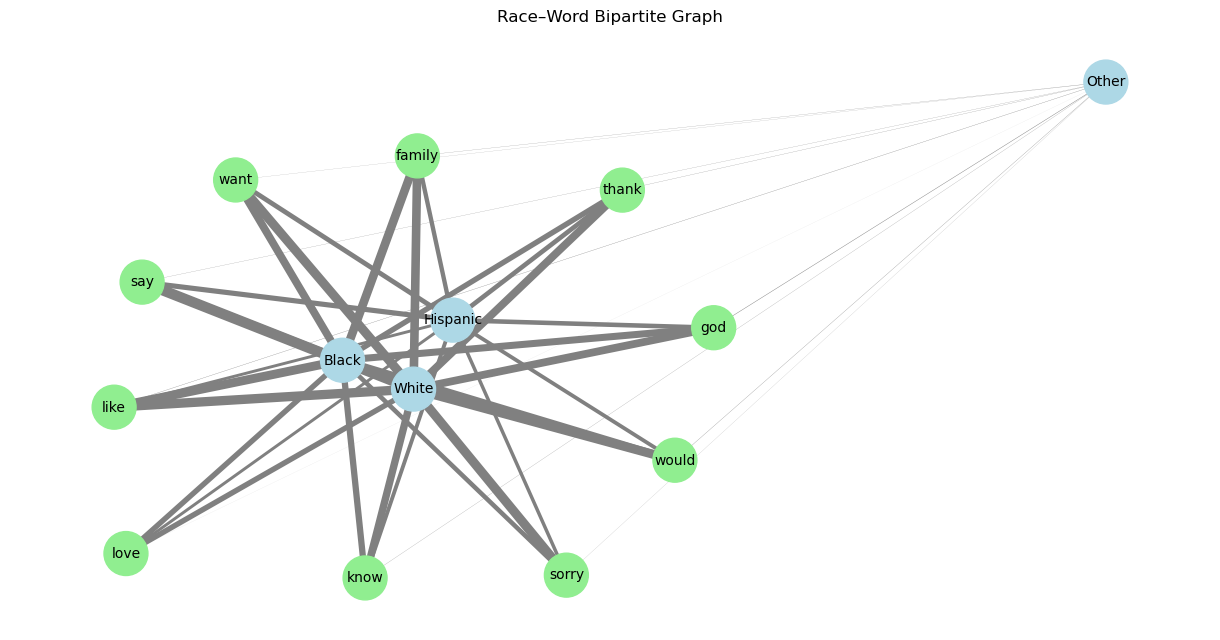

In [426]:
from collections import defaultdict

wc_race = defaultdict(int)

for node_A, node_B in B.edges():
    # if person <-> word format
    if B.nodes[node_A]["node_type"] == "person":
        race = B.nodes[node_A]["race"]
        word = node_B
    # if word <-> person format
    else:
        race = B.nodes[node_B]["race"]
        word = node_A
    wc_race[(race, word)] += 1

CWR = nx.Graph()

# Add nodes for race categories
races = set(race for (race, word) in wc_race)
for race in races:
    CWR.add_node(race, node_type="race", bipartite=0)

# Add word nodes
words = set(word for (race, word) in wc_race)
for word in words:
    CWR.add_node(word, node_type="word", bipartite=1)

# Add edges with weights representing word usage as proportion of total word usage
for (race, word), count in wc_race.items():
    total = dict(top_words)[word]
    CWR.add_edge(race, word, weight=count/total)

edge_weights1 = [CWR[u][v]["weight"] for u, v in CWR.edges()]
scaled_widths1 = [w * 25 for w in edge_weights1]

plt.figure(figsize=(12, 6))
pos = nx.spring_layout(CWR, seed=101)
node_colors1 = ["lightblue" if CWR.nodes[n]["node_type"] == "race" else "lightgreen" for n in CWR.nodes]

nx.draw(
    CWR, pos,
    with_labels=True,
    node_color=node_colors1,
    node_size=1000,
    font_size=10,
    edge_color="gray",
    width=scaled_widths1,
)
plt.title("Race–Word Bipartite Graph")
plt.show()

By adjusting the widths of the edges between the top words and the racial categories to reflect the proportion of the total usage of each word, we can see that some of the words were used more often by some groups of the executed inmates.

The same logic can be applied to the age range and year of death attributes for the inmates' nodes.

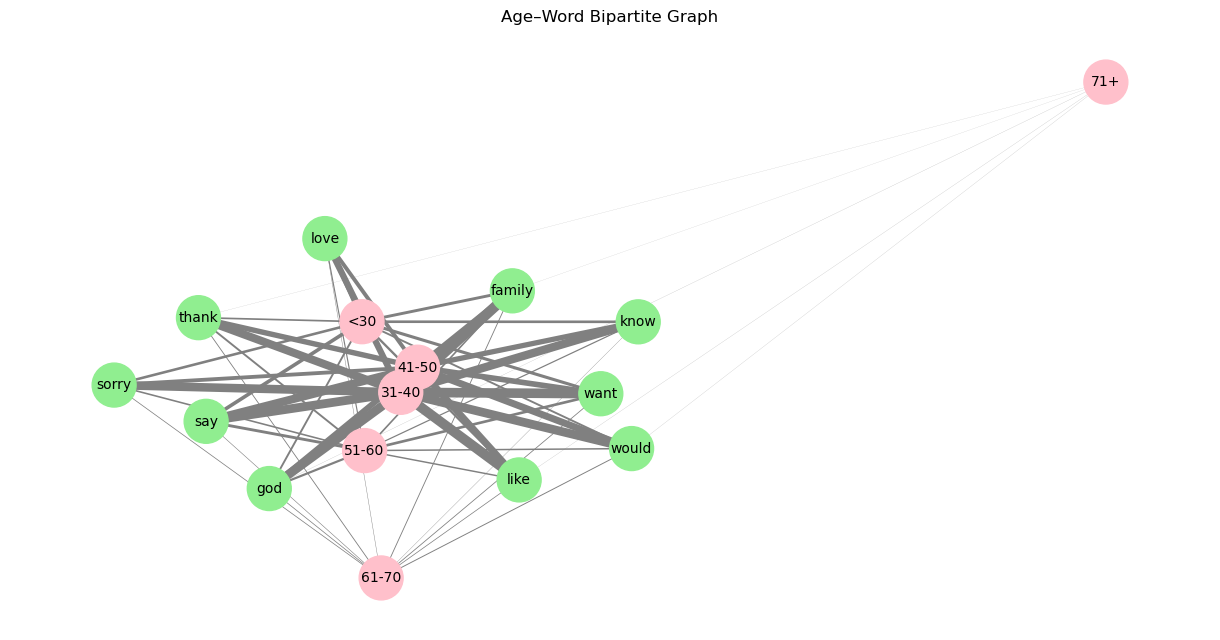

In [427]:
wc_age = defaultdict(int)

for node_A, node_B in B.edges():
    if B.nodes[node_A]["node_type"] == "person":
        age_range = B.nodes[node_A]["age_range"]
        word = node_B
    else:
        age_range = B.nodes[node_B]["age_range"]
        word = node_A
    wc_age[(age_range, word)] += 1

CWA = nx.Graph()

ranges = set(age for (age, word) in wc_age)
for age_range in ranges:
    CWA.add_node(age_range, node_type="age_range", bipartite=0)

words = set(word for (age, word) in wc_age)
for word in words:
    CWA.add_node(word, node_type="word", bipartite=1)

for (age_range, word), count in wc_age.items():
    total = dict(top_words)[word]
    CWA.add_edge(age_range, word, weight=count/total)

edge_weights = [CWA[u][v]["weight"] for u, v in CWA.edges()]
scaled_widths = [w * 25 for w in edge_weights]

plt.figure(figsize=(12, 6))
pos = nx.spring_layout(CWA, seed=101)
node_colors = ["pink" if CWA.nodes[n]["node_type"] == "age_range" else "lightgreen" for n in CWA.nodes]

nx.draw(
    CWA, pos,
    with_labels=True,
    node_color=node_colors,
    node_size=1000,
    font_size=10,
    edge_color="gray",
    width=scaled_widths,
)
plt.title("Age–Word Bipartite Graph")
plt.show()

In the case of the age range categories, the differences in edge width were likely due to the comparatively few statements from those over 50.

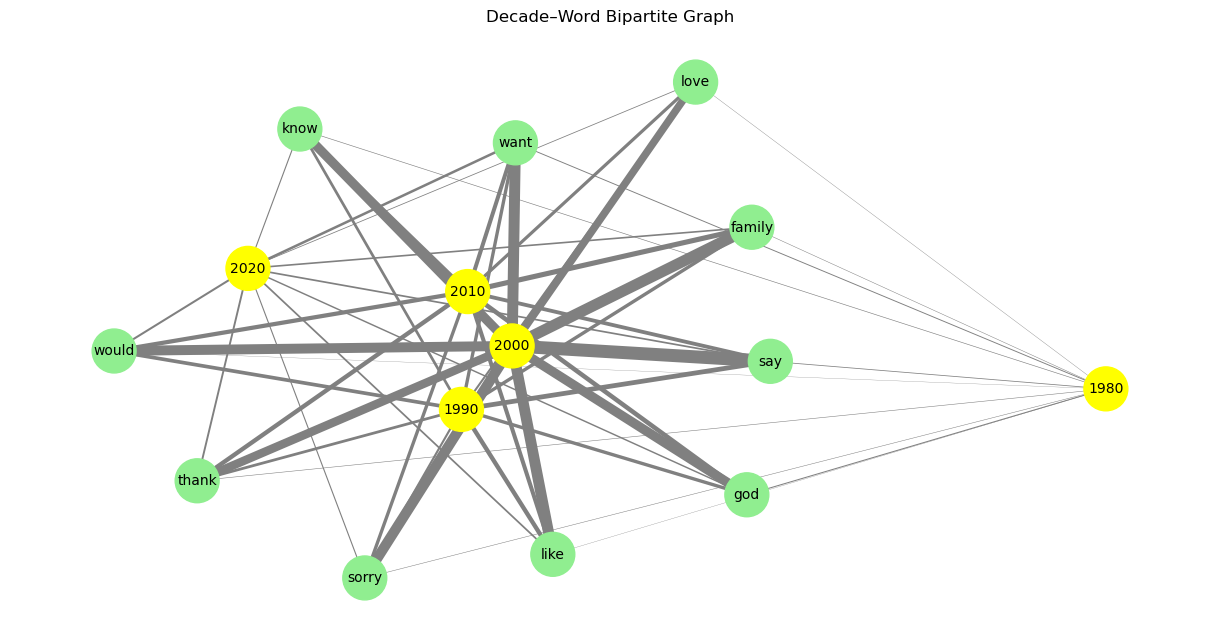

In [428]:
wc_decade = defaultdict(int)

for node_A, node_B in B.edges():
    if B.nodes[node_A]["node_type"] == "person":
        decade = B.nodes[node_A]["decade"]
        word = node_B
    else:
        decade = B.nodes[node_B]["decade"]
        word = node_A
    wc_decade[(decade, word)] += 1

CWD = nx.Graph()

decades = set(decade for (decade, word) in wc_decade)
for decade in decades:
    CWD.add_node(decade, node_type="decade", bipartite=0)

words = set(word for (decade, word) in wc_decade)
for word in words:
    CWD.add_node(word, node_type="word", bipartite=1)

for (decade, word), count in wc_decade.items():
    total = dict(top_words)[word]
    CWD.add_edge(decade, word, weight=count/total)

edge_weights = [CWD[u][v]["weight"] for u, v in CWD.edges()]
scaled_widths = [w * 25 for w in edge_weights]

plt.figure(figsize=(12, 6))
pos = nx.spring_layout(CWD, seed=101)
node_colors = ["yellow" if CWD.nodes[n]["node_type"] == "decade" else "lightgreen" for n in CWD.nodes]

nx.draw(
    CWD, pos,
    with_labels=True,
    node_color=node_colors,
    node_size=1000,
    font_size=10,
    edge_color="gray",
    width=scaled_widths,
)
plt.title("Decade–Word Bipartite Graph")
plt.show()

There appears to be a more of a connection between the usage of certain words and the decade in which the inmate was executed, though we have fewer statements overall for the most recent decade.

# Summary

I have been sobered by this process of examining the final statements of death row inmates executed in Texas since 1982. In this analysis, there appears to be some commonality in the emotions and thoughts of those facing death. The words they chose to express themselves appeared mostly to be simple, everyday language that nearly every human can relate to and understand.

Using NLP to examine specific data around word usage and network analysis to find connections between those words, my conclusion is that most statements included positive concepts like "love", "family", "god" and gratitude, while also expressing regret or desire in words like "sorry", "would" and "want". In their words, I was somewhat surprised to find few expressions of anger, despair or denial.

My hope is that studies like this can bring connection and comfort to all of us who must one day face the end of our lives. Data can seem cold and unemotional, but we can and must use it appropriately to bring value and knowledge to all.